# SA_Large_20184757_주영석

In [1]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [2]:
# Plot Settings
PLOT_MODE = True # Draw Route
PLT_INTERVAL = 100 # Draw Route every 100 iterations
plt.ion()

In [15]:
def fileloader():
    with open(file_path, "r") as file:
        file_str = file.readlines()
    
    coord_start_idx = 8
    for line in range(2,len(file_str)-1):
        if 'NODE_COORD_SECTION' in file_str[line]:
            coord_start_idx = line + 1
    # Get the coordinates of cities
    coord_str = file_str[coord_start_idx:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = float(items[1]), float(items[2])

    return coord_list

In [4]:
def path_cost(path, path_map):
    # The array of cost between cities in the path
    cnt_cities = path.shape[0]-1
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]
    return cost_arr

## Cluster

In [5]:
# clusterize cities with K-Means clustering algorithm
def cluster(coord_list, n_cluster, path_map):
    KMean = KMeans(init='k-means++', n_clusters=n_cluster, max_iter=50)
    KMean.fit(coord_list)
#     print('kmean')
    
    # construct path map of clusters with minimum distances between clusters
    cluster_path_map = np.zeros((n_cluster, n_cluster))
    for l1 in range(0, n_cluster):
        for l2 in range(l1+1, n_cluster):
            path_map_slice = path_map[np.ix_(np.where(KMean.labels_ == l1)[0], np.where(KMean.labels_ == l2)[0])]
            min_dist = np.min(path_map_slice)
            cluster_path_map[l1,l2], cluster_path_map[l2,l1] = min_dist, min_dist
    
    return cluster_path_map, KMean.labels_

## Greedy

In [6]:
# greedy function for inter cluster path
def greedy_cluster(n_cluster, cluster_path_map):
    cluster_path = np.zeros(n_cluster+1, dtype=np.int32)
    clusters_tovisit = np.ones((n_cluster), dtype=np.bool_)
    clusters_tovisit[0] = False
    for i in range(1, n_cluster):
        start_idx = cluster_path[i - 1]
        distance_from_start = cluster_path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            if clusters_tovisit[nearest_list[idx]]:
                nearest_cluster = nearest_list[idx]
                break
        clusters_tovisit[nearest_cluster] = False
        cluster_path_map[start_idx, nearest_cluster] = np.inf
        cluster_path[i] = nearest_cluster
    return cluster_path

In [7]:
# greedy function for single cluster path
def greedy_cities(city_idx, path_map, start_idx, end_idx):
    cities_path = np.zeros(city_idx.shape[0], dtype=np.int32)
    cities_path[0], cities_path[-1] = start_idx, end_idx
    cities_path_map = np.full(path_map.shape, fill_value=np.inf)
    cities_path_map[np.ix_(city_idx, city_idx)] = path_map[np.ix_(city_idx, city_idx)]
    cities_tovisit = np.ones((path_map.shape[0]), dtype=np.bool_)
#     np.where(cities_path_map<np.inf,True,False)
    cities_tovisit[start_idx] = False
    cities_tovisit[end_idx] = False
    for i in range(1, city_idx.shape[0] - 1):
        start_idx = cities_path[i - 1]
        distance_from_start = cities_path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        
        cities_path_map[start_idx, nearest_city] = np.inf
        
        cities_path[i] = nearest_city
    return cities_path

## Local Transformation

In [8]:
# block reverse mutation(transformation) function
def block_reverse(path):
    path_len = path.shape[0]
    sel_idx = np.sort(np.random.choice(np.arange(1, path_len), 2))
    new_path = path.copy()
    new_path[sel_idx[0]:sel_idx[1]] = np.flip(path[sel_idx[0]:sel_idx[1]])
    return new_path

In [9]:
# block insert mutation(transformation) function
def block_insert(path):
    path_len = path.shape[0]
    sel_idx = np.sort(np.random.choice(np.arange(1, path_len), 3))
    new_path = path.copy()
    new_path[sel_idx[0]:sel_idx[0]+sel_idx[2]-sel_idx[1]] = path[sel_idx[1]:sel_idx[2]]
    new_path[sel_idx[0]+sel_idx[2]-sel_idx[1]:sel_idx[2]] = path[sel_idx[0]:sel_idx[1]]
    return new_path

In [10]:
# vertex insert mutation(transformation) function
def vertex_insert(path):
    path_len = path.shape[0]
    sel_idx = np.sort(np.random.choice(np.arange(1, path_len-1), 2))
    new_path = path.copy()
    new_path[sel_idx[0]+1:sel_idx[1]+1] = path[sel_idx[0]:sel_idx[1]]
    new_path[sel_idx[0]] = path[sel_idx[1]]
    return new_path

## SA

In [31]:
# single adaptive two-stage simulated annealing function for given path
def sa(path, path_map, time_coef=1.):
    
    # initial path, cost
    path_len = path.shape[0]
    path_current = path.copy()
    cost_current = np.sum(path_cost(path, path_map))
    
    if path_len == 2:
        return path_current, cost_current
    
    # set constants
    t_initial = 1000.
    # optimal solution cost set as pseudo value
    OPT_pseudo = cost_current / 3.
    
    # stage-1
    # set variables
    t_end = 0.005
    t_greedy = path_len // 3
    # time_coef controls cooling ratio and execution time
    t_cool = (16. * time_coef * np.sqrt(path_len) - 1.) / (16. * time_coef * np.sqrt(path_len))
    
    G = 0
    t_current = t_initial
    
    while t_current >= t_end:
        
        new_path_list = []
        new_cost_list = []
        
        # make t_greedy neighborhood solution paths
        while G < t_greedy:
            
            path_new = None
            
            random_mutation_selection = np.random.randint(100)
            if random_mutation_selection < 89:
                path_new = block_reverse(path_current)
            elif random_mutation_selection > 89:
                path_new = vertex_insert(path_current)
            else:
                path_new = block_insert(path_current)

            cost_new = np.sum(path_cost(path_new, path_map))

            if cost_new <= cost_current:
                path_current = path_new
                cost_current = cost_new
                break
            else:
                new_path_list.append(path_new)
                new_cost_list.append(cost_new)
                G += 1
                
        if G == t_greedy:
            # acceptance probability
            new_cost_list = np.array(new_cost_list)
            p = np.exp(-((np.min(new_cost_list) - cost_current) / t_current) * (10. * path_len / OPT_pseudo))
            if np.random.rand(1) < p:
                path_current = new_path_list[np.argmin(new_cost_list)]
                cost_current = np.min(new_cost_list)
        
        G=0
        # cool temperature
        t_current *= t_cool
    
    
    # stage-2
    # set variables
    t_end = 0.0025
    t_greedy = 3 * path_len // 2
    t_cool = (12. * time_coef * np.sqrt(path_len) - 1.) / (12. * time_coef * np.sqrt(path_len))
    
    G = 0
    t_current = t_initial
    
    while t_current >= t_end:
        
        new_path_list = []
        new_cost_list = []
        
        while G < t_greedy:
            
            path_new = None
            
            random_mutation_selection = np.random.randint(100)
            if random_mutation_selection < 89:
                path_new = block_reverse(path_current)
            elif random_mutation_selection > 89:
                path_new = vertex_insert(path_current)
            else:
                path_new = block_insert(path_current)

            cost_new = np.sum(path_cost(path_new, path_map))

            if cost_new <= cost_current:
                path_current = path_new
                cost_current = cost_new
                break
            else:
                new_path_list.append(path_new)
                new_cost_list.append(cost_new)
                G += 1
                
        if G == t_greedy:
            p = np.exp(-((np.min(np.array(new_cost_list)) - cost_current) / t_current) * (10. * path_len / OPT_pseudo))
            if np.random.rand(1) < p:
                new_cost_list = np.array(new_cost_list)
                path_current = new_path_list[np.argmin(new_cost_list)]
                cost_current = np.min(new_cost_list)
        
        G=0
        t_current *= t_cool
    
    return path_current, cost_current

## SA_Large

In [32]:
def sa_large(coord_list):
    # set cluster number with the squared root of the number of cities
    n_cluster = int(np.floor(np.sqrt(coord_list.shape[0])))
    
    sa_large_start = time.time()
    
    # construct path map
    path_map = euclidean_distances(coord_list, coord_list)
#     print('path_map', time.time() - sa_large_start)
    
    # clusterize cities
    cluster_path_map, cluster_labels = cluster(coord_list, n_cluster, path_map)
#     print('cluster', time.time() - sa_large_start)
    
    # construct greedy path between clusters
    cluster_path = greedy_cluster(n_cluster, cluster_path_map)
#     print('greedy_cluster', time.time() - sa_large_start)
    
    # run sa for path between clusters
    sa_time = time.time()
    cluster_path, cluster_cost = sa(cluster_path, cluster_path_map)
    # measure time for single sa
    sa_time = time.time() - sa_time
#     print('sa_cluster', time.time() - sa_large_start)
    
    # make path list
    path_list = []
    cost_list = np.zeros((n_cluster))
    
    # find start and end cities in a cluster with path between clusters
    curr_cluster_idx = np.where(cluster_labels == cluster_path[-1])[0]
    path_map_slice = path_map[np.ix_(np.where(cluster_labels == cluster_path[-2])[0], curr_cluster_idx)]

    slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
    start_idx = curr_cluster_idx[slice_idx[1]]

    # iterate for all clusters
    for c in tqdm(range(n_cluster)):
        next_cluster_idx = np.where(cluster_labels == cluster_path[c+1])[0]
        path_map_slice = path_map[np.ix_(curr_cluster_idx, next_cluster_idx)]
        
        slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
        end_idx = curr_cluster_idx[slice_idx[0]]
        next_start_idx = next_cluster_idx[slice_idx[1]]

        while start_idx == end_idx:
            # if start and end cities are duplicate, select another city as end city
            path_map_slice[slice_idx] = np.inf
            slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
            end_idx = curr_cluster_idx[slice_idx[0]]
            next_start_idx = next_cluster_idx[slice_idx[1]]
    
        # construct greedy path for single cluster 
        path_cluster = greedy_cities(curr_cluster_idx, path_map, start_idx, end_idx)
        path_list.append(path_cluster)
        cost_list[c] = path_cost(path_cluster, path_map).sum()

        start_idx = next_start_idx
        curr_cluster_idx = next_cluster_idx
    
#     print('greedy', time.time() - sa_large_start)
    # calculate time coefficient with the initial sa execution time and remaining time
    time_coef = np.abs((((55. - (time.time()-sa_large_start)) / n_cluster) - 0.1) / sa_time)

    # iterate from largest cost cluster
    for idx in tqdm(np.argsort(cost_list)[::-1]):
        if time.time() - sa_large_start > 58:
            # detect timeout
            break
        # run sa of single cluster
        path_cluster, cost_cluster = sa(path_list[idx], path_map, time_coef)
        path_list[idx] = path_cluster
    
    # conquer all solution paths
    best_path = np.concatenate([np.concatenate(path_list), np.array(path_list[0][:1])])
    best_cost = path_cost(best_path, path_map).sum()
    
    if PLOT_MODE:
        plt.close()
        figure, ax = plt.subplots()
    #     plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
        for l in range(0, n_cluster+1):
            plt.scatter(coord_list[cluster_labels == l, 0], coord_list[cluster_labels == l,1], label=l, s=2)
        plt.title('City Route')
        coord_path = coord_list
        coord_path = np.append(coord_path, coord_path[best_path[0], :].reshape(1, 2), axis=0)
        coord_path[:, :] = coord_path[best_path, :]
        lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--', linewidth=1)
        figure.canvas.draw()
        figure.canvas.flush_events()
        plt.show()
        
    return best_path, best_cost

## Main

In [39]:
file_path = 'tsplib/fi10639.tsp'

100%|█████████████████████████████████████████| 103/103 [00:40<00:00,  2.53it/s]


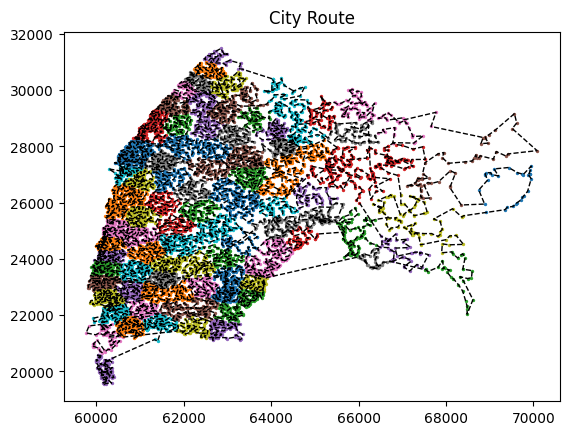

Execution Time: 54.80928897857666
Path: [7001, 6918, 6967, 7044, 6824, 6795, 6823, 6651, 6591, 6652, 6592, 6523, 6482, 6364, 6226, 6080, 6041, 5946, 5832, 5833, 6013, 6156, 6116, 6227, 6117, 6157, 6014, 5947, 6015, 6082, 6042, 6158, 6119, 5910, 5836, 5835, 5909, 5834, 5711, 5747, 5795, 5908, 5794, 5582, 5642, 5614, 5583, 5547, 5615, 5616, 5643, 5712, 5911, 6043, 6044, 6408, 6366, 6483, 6654, 6968, 6872, 7002, 7206, 7244, 6825, 6766, 6689, 6524, 6559, 6653, 6525, 6334, 6189, 6081, 6118, 6228, 6262, 6299, 6407, 6333, 6365, 6444, 6481, 6443, 6522, 6688, 7241, 7303, 7462, 7495, 7604, 7549, 7548, 7523, 7522, 7368, 7270, 7127, 7428, 7520, 7579, 7519, 7494, 7578, 7518, 7493, 7461, 7603, 7624, 7655, 7787, 7819, 7736, 7623, 7684, 7767, 7711, 7766, 7765, 7864, 7840, 7841, 7865, 7892, 7942, 7941, 7965, 8033, 8032, 8124, 8125, 8179, 8094, 8034, 8011, 7943, 7913, 7966, 7988, 8068, 8127, 8036, 8069, 8037, 8038, 7967, 7914, 7944, 7915, 7866, 7893, 7842, 7737, 7685, 7625, 7626, 7580, 7521, 7581, 7582,

In [40]:
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
best_path, best_cost = sa_large(coord_list)
print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))

In [42]:
file_path = 'tsplib/d18512.tsp'

100%|████████████████████████████████████████| 136/136 [00:01<00:00, 127.98it/s]


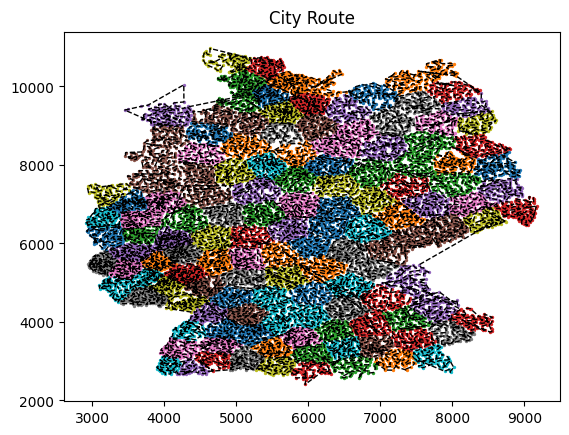

Execution Time: 46.26274490356445
Path: [14314, 14357, 14378, 14403, 14382, 14452, 14525, 14538, 14604, 14595, 14565, 14545, 14570, 14612, 14692, 14706, 14667, 14703, 14728, 14760, 14789, 14802, 14847, 14889, 14931, 14937, 14979, 15031, 15092, 15081, 15126, 15155, 15100, 15074, 15046, 15078, 15040, 15002, 15036, 14988, 14926, 14883, 14864, 14814, 14794, 14733, 14774, 14677, 14646, 14633, 14551, 14498, 14496, 14442, 14419, 14396, 14367, 14324, 14326, 14362, 14385, 14375, 14411, 14447, 14343, 14321, 14416, 14467, 14480, 14527, 14566, 14579, 14543, 14489, 14448, 14401, 14365, 14342, 14363, 14350, 14370, 14445, 14435, 14500, 14521, 14576, 14603, 14637, 14701, 14679, 14732, 14754, 14799, 14795, 14783, 14709, 14597, 14614, 14778, 14761, 14730, 14689, 14659, 14611, 14781, 14855, 14851, 14850, 14900, 14948, 15006, 14952, 14978, 14938, 14960, 14943, 14893, 15067, 15135, 15184, 15132, 15095, 14998, 15004, 14897, 14925, 14875, 14828, 14769, 14782, 14838, 14945, 14876, 14441, 14249, 14250, 14262, 

In [43]:
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
best_path, best_cost = sa_large(coord_list)
print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))

In [44]:
file_path = 'tsplib/vm22775.tsp'

  0%|                                                   | 0/150 [00:00<?, ?it/s]


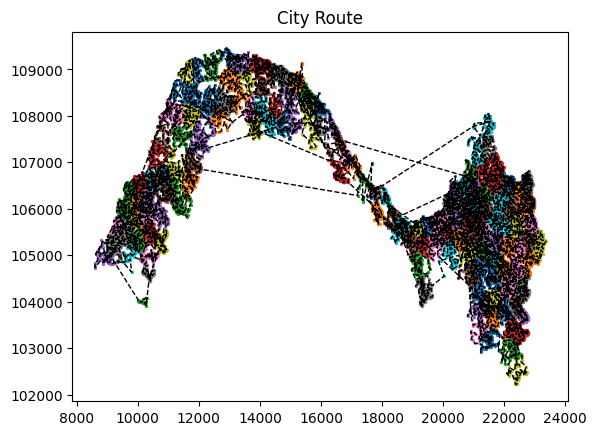

Execution Time: 72.21089506149292
Path: [15812, 15744, 15745, 15813, 15895, 15984, 16068, 15985, 16069, 16157, 16243, 16244, 16245, 16332, 16333, 16410, 16496, 16495, 16409, 16494, 16589, 16590, 16591, 16684, 16769, 16846, 16845, 16925, 16926, 16847, 16848, 16770, 16686, 16687, 16593, 16592, 16497, 16411, 16412, 16413, 16498, 16334, 16248, 16249, 16159, 16250, 16072, 15988, 16071, 16158, 16247, 16246, 16070, 15986, 15987, 15896, 15897, 15815, 15747, 15670, 15582, 15506, 15428, 15507, 15508, 15429, 15354, 15274, 15200, 15199, 15273, 15198, 15197, 15272, 15271, 15196, 15102, 15101, 15010, 14924, 14925, 15103, 15104, 15011, 15012, 15105, 15013, 15014, 15106, 15107, 15108, 15202, 15355, 15430, 15201, 15353, 15352, 15427, 15426, 15505, 15581, 15669, 15746, 15668, 15667, 15814, 15504, 15425, 15350, 15424, 15194, 15193, 15100, 15195, 15270, 15351, 14926, 14745, 14744, 14604, 14605, 14673, 14533, 14927, 14928, 15015, 15110, 15109, 15111, 15203, 15276, 15356, 15275, 14929, 15509, 15672, 15818, 

In [45]:
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
best_path, best_cost = sa_large(coord_list)
print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))

# 클러스터 내의 시작점, 끝점 알아내는 시간이 너무 오래 걸릴 경우 => 클러스터 내 시작점과 끝점 랜덤 지정하고 sa에다가 이전 클러스터 마지막 점, 이후 클러스터 시작 점 같이 넣어버리는건 어때?

#### 대규모 데이터에 대해 TSP를 해결하기 위해, Divide and Conquer를 적용한다. Divide 과정에는 클러스터링 알고리즘을 적용한다. 클러스터 간의 경로와 클러스터 내부의 경로에 각각 SA 알고리즘을 적용하여, 한꺼번에 모든 도시에 대한 경로를 초기화하고 하는 것에 비해 시간복잡도를 줄인다. SA 알고리즘의 경우 Adaptive SA 알고리즘을 적용한다. Adaptive SA는 데이터의 크기에 따라 Cooling Ratio등의 상수를 조절하여 매번 상수 조절을 해야하는 필요성을 없애준다. 여기에 추가적으로 시간을 조절하도록 하는 상수를 넣어 각 클러스터의 SA 알고리즘 동작시간을 제어한다.

#### 우선, 주어진 도시를 K-Means 알고리즘을 이용하여 클러스터링한다. 클러스터의 개수는 도시의 개수의 제곱근으로 설정한다. 계산된 클러스터 간의 경로를 이용해 각 클러스터의 시작 도시와 끝 도시를 구하고, Greedy 알고리즘으로 경로를 구축한다. 그 다음으로, 남은 시간을 계산하여 각 클러스터의 SA 알고리즘 동작 시간을 조절한다. 클러스터의 개수와 각 클러스터 내의 도시의 개수가 거의 일치하므로, 클러스터 간의 경로에 대한 SA 알고리즘의 동작 시간이 각 클러스터의 SA 알고리즘 동작시간의 평균에 일치할 것으로 가정하고, 시간을 계산한다. 그래도 오차로 인해 시간이 초과될 수 있으므로 Cost가 가장 큰 클러스터부터 시작하여 SA 알고리즘을 적용한다. 마지막으로 모든 클러스터의 경로를 합친다.

#### National TSP 데이터로 실험한 결과, 도시의 개수가 18512개인 d18512.tsp 데이터에 대해서는 시간 초과 없이 잘 작동한다. 그러나 이 이상의 도시 개수가 주어졌을 때에는 각 클러스터의 Solution Path를 Greedy 알고리즘으로 초기화하는 과정에서부터 60초를 초과하는 시간이 걸리는 것으로 확인했다. 각 클러스터에서 출발 도시와 끝 도시를 구하는 과정과 Greedy 알고리즘을 실행하기 위해 path_map등의 초기화 등 많은 양의 배열 연산이 요구되는 것이 원인일 것으로 생각된다. Masked Array를 이용하는 등 여러가지 방법으로 해결하려고 시도해보았으나, 현재 구현한 방법이 가장 실행 시간이 적음을 확인했다.

X Geng, Z Chen, W Yang, D Shi, K Zhao, Solving the traveling salesman problem based on an adaptive simulated annealing algorithm with greedy search, Applied Soft Computing, Volume 11, Issue 4, 2011, https://doi.org/10.1016/j.asoc.2011.01.039.